# Procrustes Tutorial

## Installation

Make sure all the dependencies are installed  
Python >= 2.7, or Python >= 3.6: http://www.python.org/  
PIP >= 9.0: https://pip.pypa.io/  
SciPy >= 1.0.0: http://www.scipy.org/  
NumPy >= 1.14: http://www.numpy.org/  
Nosetests >= 1.3.7: http://readthedocs.org/docs/nose/en/latest/ 

In [ ]:
# download the source code 
git clone https://github.com/QuantumElephant/procrustes.git

In [ ]:
# one way to install the package 
./setup.py install --user 

In [ ]:
# Or by using the python package manager pip 
# https://pypi.org/project/pip/ 
pip install -e ./ --user 

In [ ]:
# Make sure you have installed the package correctly 
nosetests procrustes/. 

In [ ]:
# To uninstall the package 
pip uninstall procrustes 

## Basic Usage

In [83]:
# Run code from here
# import libraries
import numpy as np
from procrustes import * 

In [84]:
# Define array_a
array_a = np.array([[-7.3, 2.8], [-7.1, -0.2],
                    [ 4. , 1.4], [ 1.3,  0. ]])

In [85]:
# Define array_b
array_b = np.array([[-5.90207845, -5.12791088], 
                    [-6.74021234, -2.24043246], 
                    [ 4.23759847, 0.05252849], 
                    [ 1.22159856, 0.44463126]])

In [86]:
# Find the orthogonal matrix by Procrustes
new_a, new_b, array_u, error_opt = orthogonal(array_a, array_b,
                                              remove_zero_col=True,
                                              remove_zero_row=True,
                                              translate=False, scale=False)

In [87]:
# the orthogonal matrix
array_u

array([[ 0.9396912 ,  0.34202404],
       [ 0.34202404, -0.9396912 ]])

In [88]:
# the error
error_opt

6.63247363302363e-17

In [89]:
# Getting help
# Documentation
symmetric?

## Molecule alignment

We will use Two sided permutation Procrustes with one transformation to alignment two organic molecules.
![](images/mol_align1.jpg)

In [90]:
from procrustes import _utils

In [92]:
A = np.array([[6, 3, 0, 0],
              [3, 6, 1, 0],
              [0, 1, 6, 2],
              [0, 0, 2, 6]])

In [93]:
B = np.array([[6, 3, 0, 0, 0, 0, 0],
              [3, 6, 1, 0, 0, 0, 0],
              [0, 1, 6, 1, 0, 1, 1],
              [0, 0, 1, 6, 2, 0, 0],
              [0, 0, 0, 2, 6, 0, 0],
              [0, 0, 1, 0, 0, 6, 0],
              [0, 0, 1, 0, 0, 0, 6]])

In [94]:
def mol_align(A, B):
    r"""Align two molecules using two sided permutation Procrustes with one
    transformation.
    """
    # Compute the permutation matrix
    _, _, U, e_opt = permutation_2sided(
        A, B, transform_mode='single_undirected',
        remove_zero_col=False, remove_zero_row=False)
    # Compute the transformed molecule A
    A, _ = _utils._get_input_arrays(A, B, 
                                    remove_zero_col=False,
                                    remove_zero_row=False,
                                    translate=False,
                                    scale=False, check_finite=False)
    new_A = np.dot(U.T, np.dot(A, U))
    # B
    new_B = B

    return new_A, new_B, U, e_opt

In [95]:
new_A, new_B, U, e_opt = mol_align(A, B)

In [96]:
new_A

array([[6., 3., 0., 0., 0., 0., 0.],
       [3., 6., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 6., 2., 0., 0.],
       [0., 0., 0., 2., 6., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

## Protein Scaffold Alignment

Align chain A and chain C of human deoxyhemoglobin crystal styructure (PDB ID: 2hhb).

![](images/protein_symmetry2.png)

**Kabsch algorithm v.s. orthogonal procrustes**

In [97]:
from Bio.PDB.PDBParser import PDBParser
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [98]:
# Define a function to get the coordinates
def _get_coordinates(file_name, pdb_id, chain_id):
    # permissive parser
    p = PDBParser(PERMISSIVE=1)
    structure = p.get_structure(pdb_id, file_name)
    # get X-ray crystal structure
    matrix = []
    chain = structure[0][chain_id]

    for residue in chain:
        for atom in residue:
            # Using residue['CA'] results in error
            if atom.get_id() == 'CA':
                matrix += list(atom.get_vector())
    matrix = np.asarray(matrix).reshape(-1, 3)

    return matrix

In [99]:
# Define a function to compute the rmsd values
def _compute_rmsd(A, B):
    r"""
    Calculate root mean square deviation (rmsd).
    """

    # Check if A and B are with the same dimension
    if A.shape != B.shape:
        raise ValueError("INput matrices must be with the same shape\
                         for rmsd calculations.")
    D = len(A[0, :])
    N = len(A[:, 0])

    # Compute rmsd
    rmsd = 0.0
    for a, b in zip(A, B):
        rmsd += sum([(a[i] - b[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)

In [100]:
# the main function to align the alpha carbons
def align(file_name_A, pdb_id_A, chain_id_A,
          file_name_B, pdb_id_B, chain_id_B):
    r"""
    """

    # Get inputs coordinate matrices
    A = _get_coordinates(file_name_A, pdb_id_A, chain_id_A)
    B = _get_coordinates(file_name_B, pdb_id_B, chain_id_B)
    # Kabsch algorithm/ Procrustes rotation to
    # align protein structure
    # new_A is just the translated coordinate
    new_A, new_B, array_rot, _, = rotational(A, B,
                                             remove_zero_col=False,
                                             remove_zero_row=False,
                                             translate=True)
    # now new_A is the array after rotation
    new_A = np.dot(new_A, array_rot)
    # Compute the rmsd values
    rmsd = _compute_rmsd(new_A, new_B)

    return new_A, new_B, array_rot, rmsd

C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5037.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5080.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5124.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5167.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5211.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5269.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\St

<IPython.core.display.Javascript object>


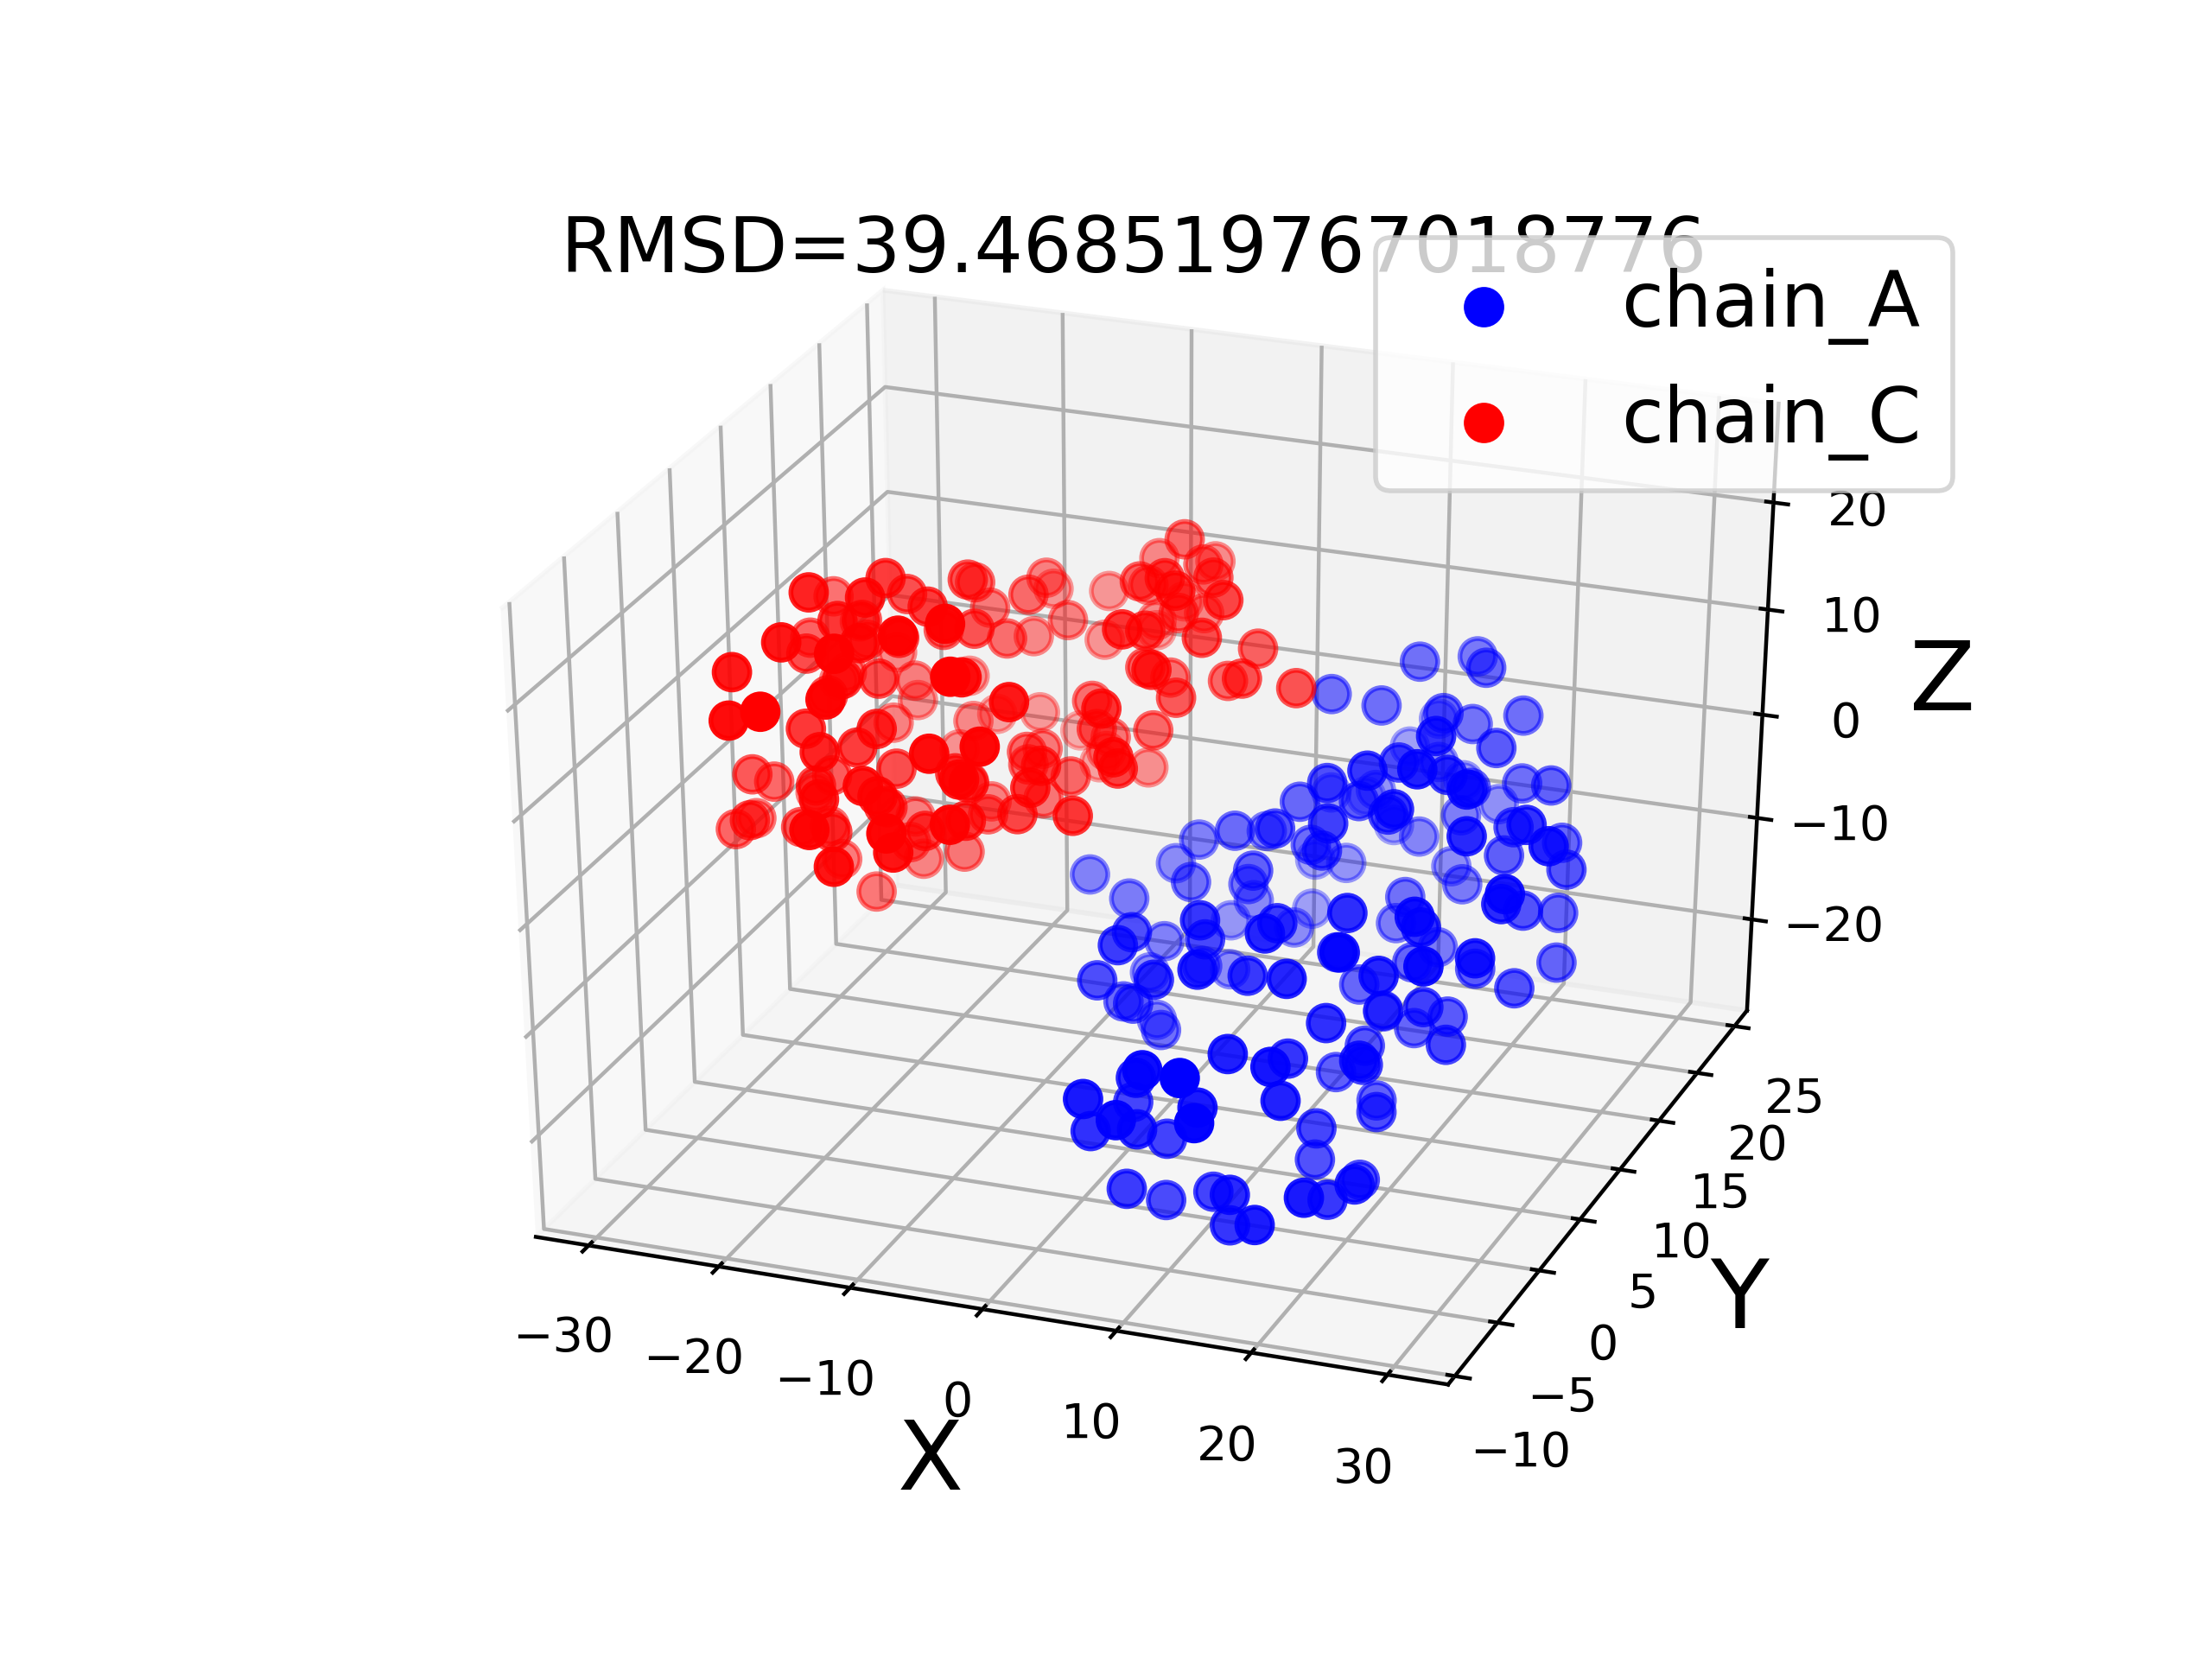

In [101]:
# plot the coordinates before align
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

# before align
A = _get_coordinates('2hhb.pdb', '2hhb', 'A')
C = _get_coordinates('2hhb.pdb', '2hhb', 'C')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(A[:,0], A[:,1], A[:,2], zdir='z', s=55, c='blue', label='chain_A')
ax.scatter(C[:,0], C[:,1], C[:,2], zdir='z', s=55, c='red', label='chain_C')

ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

rmsd=_compute_rmsd(A, C)

#ax.set_title(rmsd, fontsize=24)
ax.set_title('RMSD=39.468519767018776', fontsize=16)
ax.legend(fontsize=16)

plt.show()

C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5037.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5080.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 5124.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 5167.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5211.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\StructureBuilder.py:90: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 5269.
  PDBConstructionWarning)
C:\anaconda\lib\site-packages\Bio\PDB\St

<IPython.core.display.Javascript object>


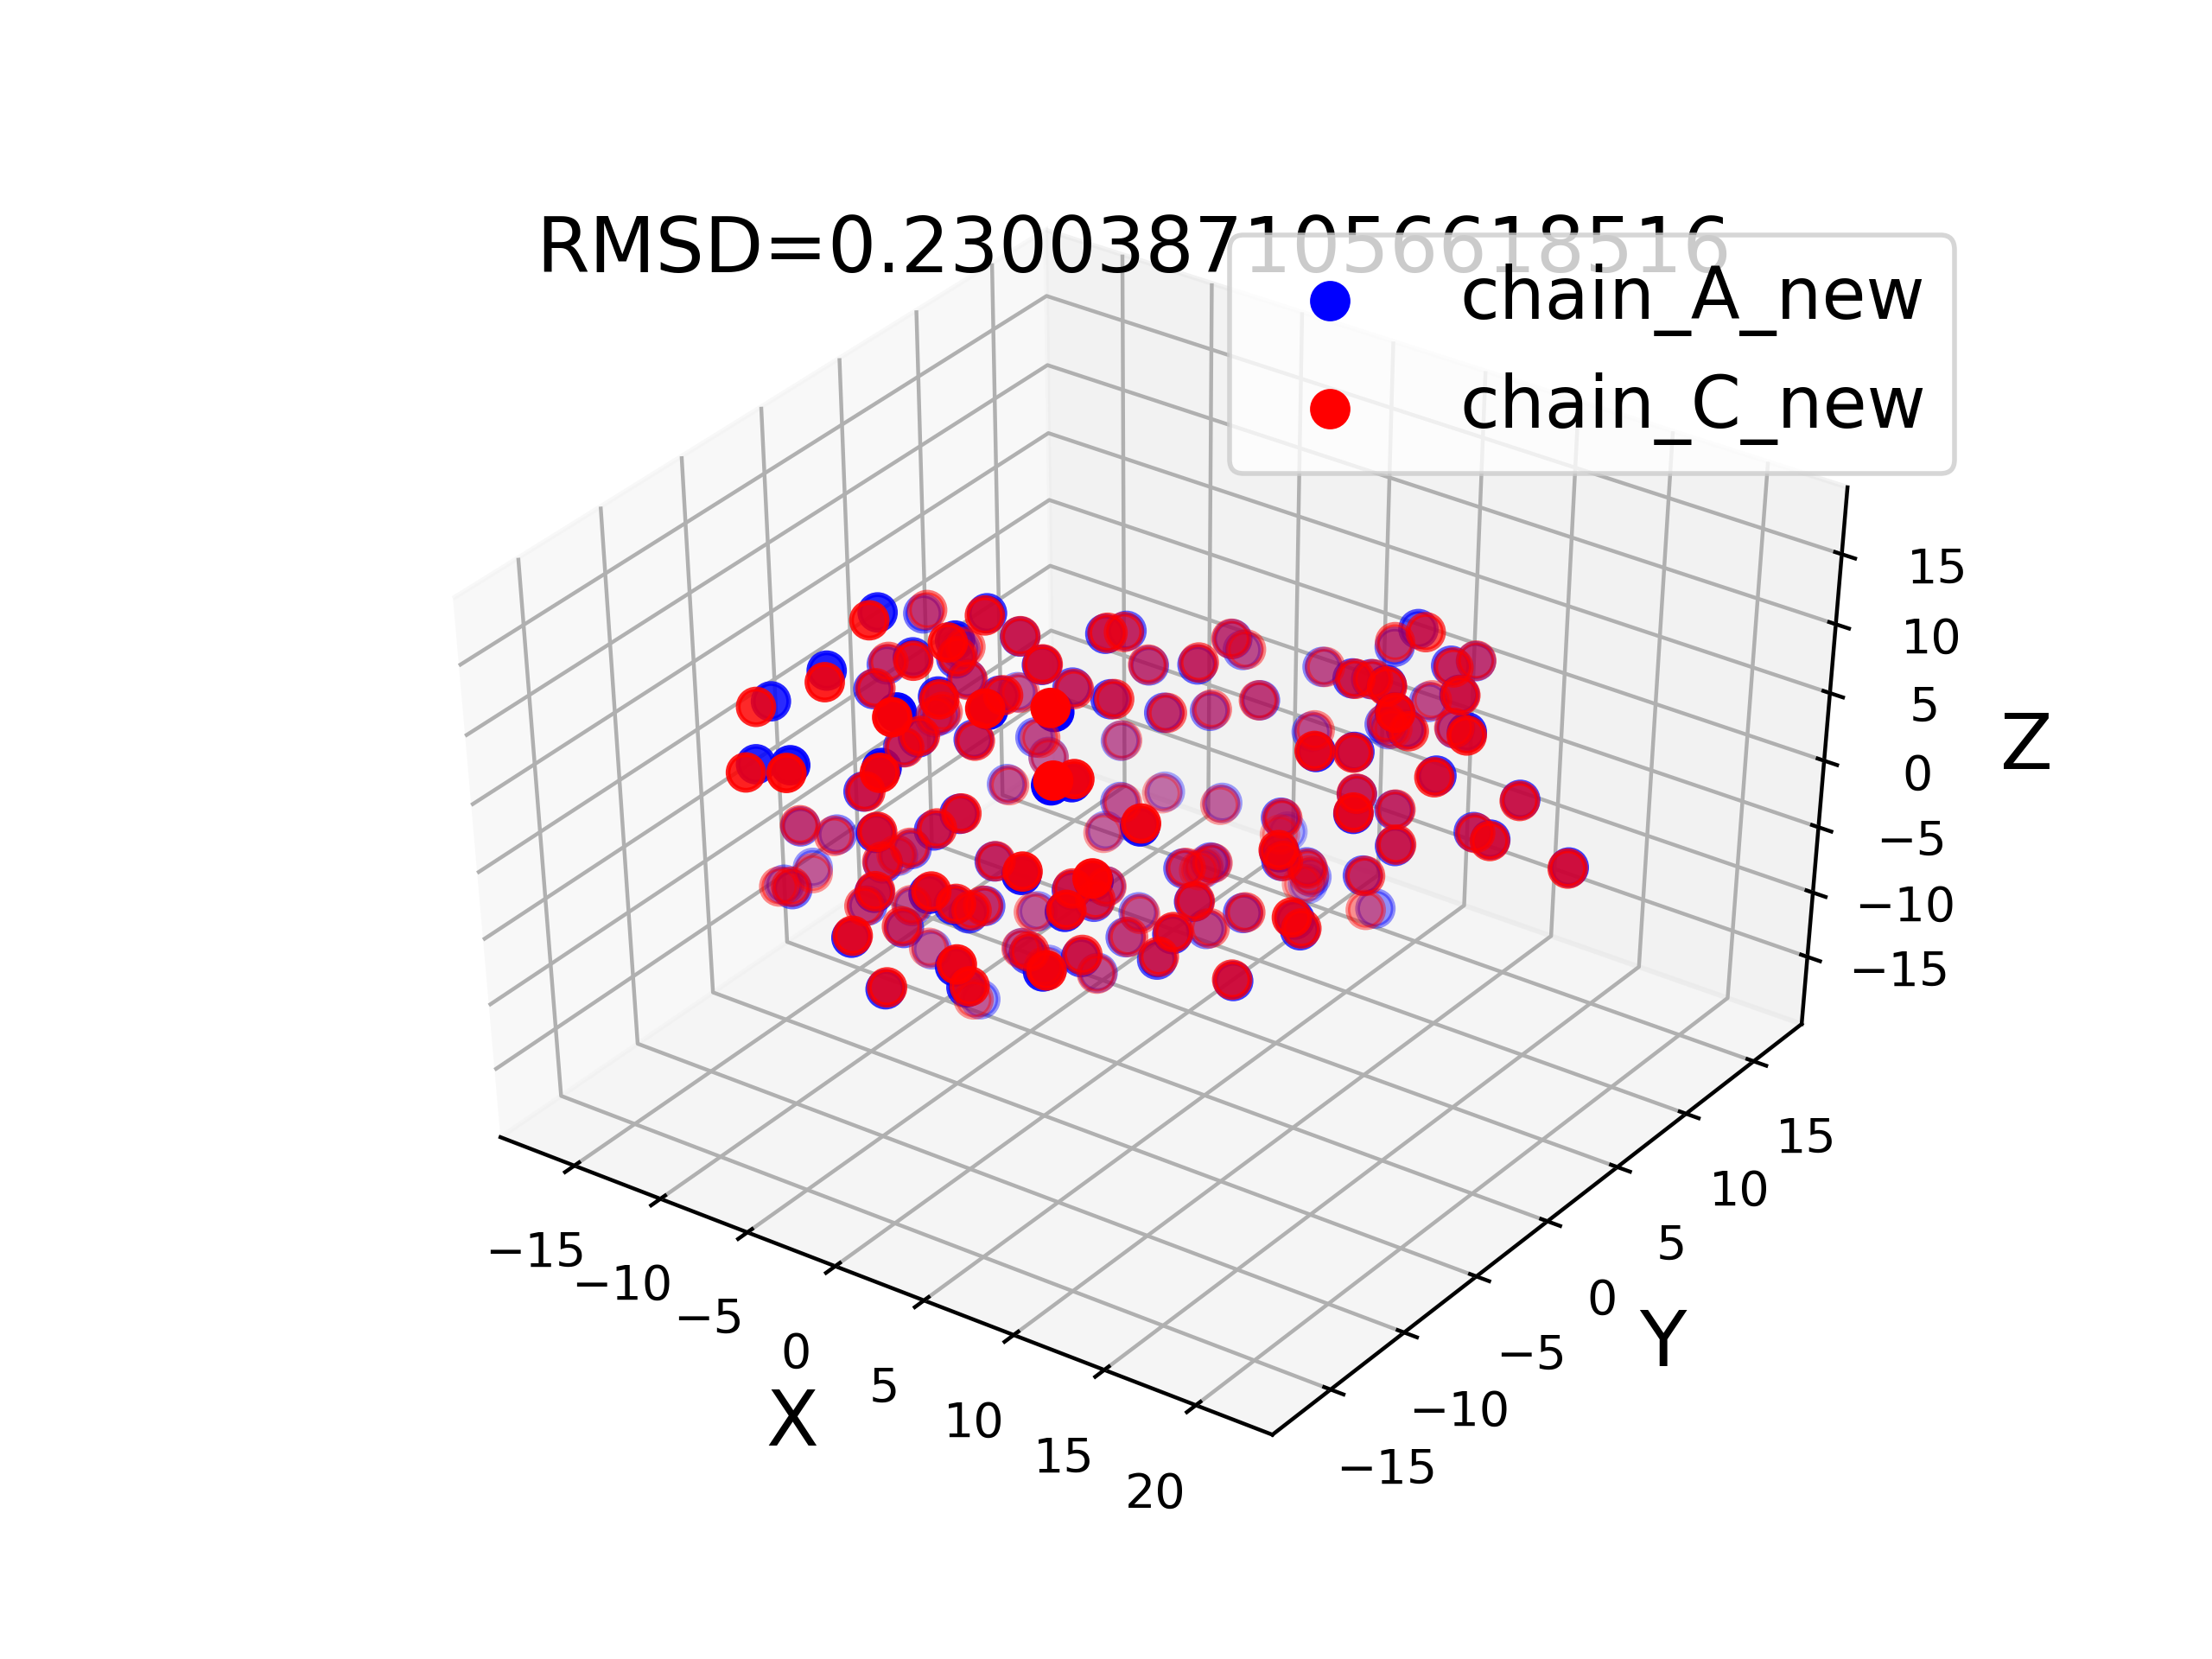

In [102]:
# after align
new_A, new_C, rot_array, rmsd = align(
    file_name_A='2hhb.pdb', pdb_id_A='2hhb', chain_id_A='A',
    file_name_B='2hhb.pdb', pdb_id_B='2hhb', chain_id_B='C')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(new_A[:,0], new_A[:,1], new_A[:,2], zdir='z', s=55,
    c='blue', label='chain_A_new')
ax.scatter(new_C[:,0], new_C[:,1], new_C[:,2], zdir='z', s=55,
    c='red', label='chain_C_new')

ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
ax.set_zlabel('Z', fontsize=16)

#ax.set_title(rmsd, fontsize=24)
ax.set_title('RMSD=0.23003871056618516', fontsize=16)
ax.legend(fontsize=15)

plt.show()

In [ ]:
new_A